Dominant Wave Direction: 112.50 degrees


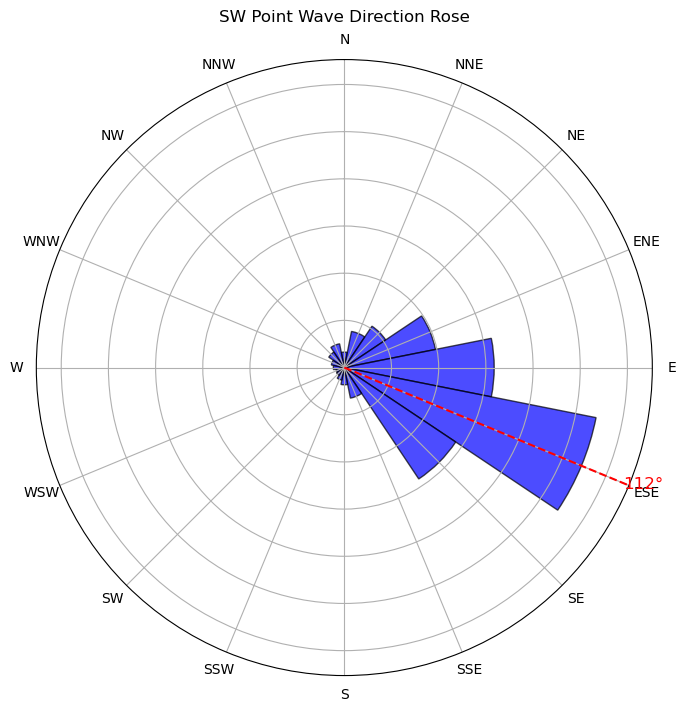

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
# Assuming the CSV file has columns 'valid_time', 'waved'
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\East point\waveswind_eastpoint.csv', parse_dates=['valid_time'])

# Extract the wave direction data
wave_directions = data['waved']

# Define the number of bins and bin width (22.5-degree bins)
num_bins = 16  # 16 bins for 22.5-degree width
bin_width = 360 / num_bins  # Calculate the width of each bin (22.5 degrees)

# Define bin centers and edges
bin_centers = np.arange(0, 360, bin_width)  # Bin centers: 0, 22.5, 45, ..., 337.5
bin_edges = np.arange(-bin_width / 2, 360 + bin_width / 2, bin_width)  # Edges span ±11.25° around centers

# Calculate histogram with the adjusted bin edges
hist, _ = np.histogram(wave_directions, bins=bin_edges, range=(0, 360))

# Identify the dominant wave direction
dominant_wave_direction_index = np.argmax(hist)
dominant_wave_direction = bin_centers[dominant_wave_direction_index]

# Output dominant direction
print(f"Dominant Wave Direction: {dominant_wave_direction:.2f} degrees")

# Convert bin centers to radians for plotting
angles = np.radians(bin_centers)
radii = hist

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, radii, width=np.radians(bin_width), color='blue', alpha=0.7, edgecolor='black')

# Highlight dominant wave direction
dominant_wave_angle = np.radians(dominant_wave_direction)
ax.axvline(dominant_wave_angle, color='red', linestyle='--', label='Dominant Wave Direction')

# Customize compass layout
ax.set_title('SW Point Wave Direction Rose', va='bottom')

# Set tick positions and labels for compass orientation
compass_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
compass_angles = np.radians(bin_centers)  # Center ticks at bin centers
ax.set_xticks(compass_angles)
ax.set_xticklabels(compass_labels)

# Set the angle offset so that North is at the top (0°)
ax.set_theta_offset(np.pi / 2)

# Set theta direction to clockwise
ax.set_theta_direction(-1)

# Extend radial limit slightly for dominant direction label
outer_radius = np.max(hist) * 1.2  # Extend radius slightly for better label visibility
ax.set_ylim(0, outer_radius)

# Add dominant direction label on outer perimeter
ax.text(dominant_wave_angle, outer_radius * 1.05, f'{int(dominant_wave_direction)}°', 
        ha='center', va='bottom', fontsize=12, color='red')

# Remove radial tick labels
ax.set_yticklabels([])

# Save and show the plot
plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Waved.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

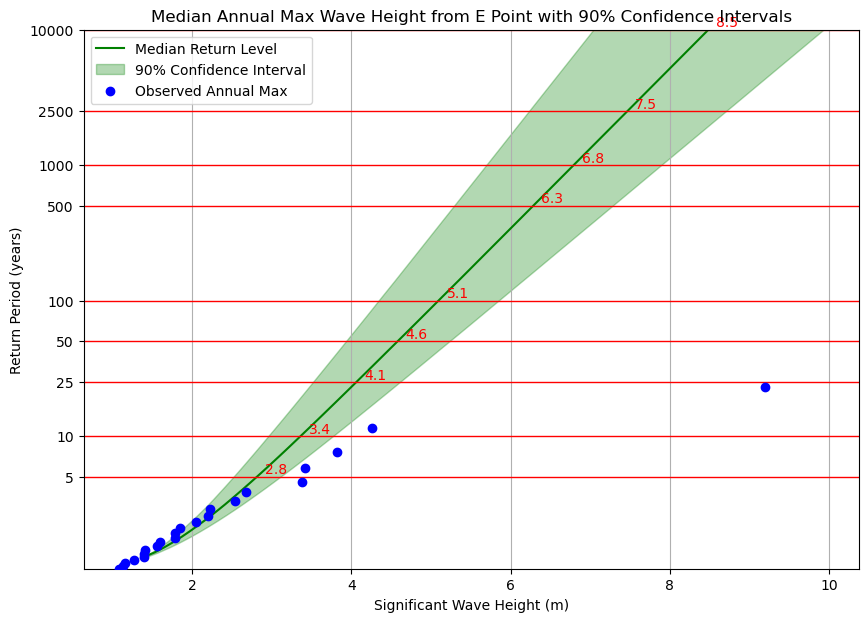

   Return Period (years)  Median Return Level Wave Height (m)  5% CI (m)  \
0                      5                             2.812091   2.517109   
1                     10                             3.362419   2.955606   
2                     25                             4.060765   3.514489   
3                     50                             4.578788   3.928709   
4                    100                             5.093580   4.339598   
5                    500                             6.281409   5.286008   
6                   1000                             6.790127   5.691121   
7                   2500                             7.464378   6.227193   
8                  10000                             8.483705   7.038432   

   95% CI (m)  Associated Wave Period (s)  
0    3.107073                    6.745692  
1    3.769232                    7.242540  
2    4.607041                    7.873023  
3    5.228867                    8.340705  
4    5.847563      

In [6]:
#method where you create synthetic data by resampling from the entire input dataset, creating annual maxima from that resampling
#synthetic annual maxima is used to calculate confidence intervals and medians
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\East point\waveswind_eastpoint.csv')
data['valid_time'] = pd.to_datetime(data['valid_time'])
directional_bin = (data['waved'] >= 146.25) & (data['waved'] <= 168.75)
filtered_data = data[directional_bin].copy()
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate annual maxima
annual_max = filtered_data.groupby('year').agg(
    max_hsig=('hsig', 'max'),
    corresponding_pp1d=('pp1d', lambda x: filtered_data.loc[x.index, 'pp1d'].values[np.argmax(x)])
).reset_index()

# Define a full range of return periods for smooth plotting
return_periods_full = np.logspace(0.1, 4, 100)  # 1 year to 10,000 years

# Bootstrapping to calculate return levels and confidence intervals
n_bootstraps = 1000  # Reduced for faster calculation; adjust as needed
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

for i in range(n_bootstraps):
    # Resample with replacement from the full dataset to calculate synthetic annual maxima
    resampled_data = filtered_data.sample(frac=1, replace=True)
    synthetic_annual_max = resampled_data.groupby('year').agg(max_hsig=('hsig', 'max')).reset_index()

    # Fit Gumbel distribution to synthetic annual maxima
    resampled_params = gumbel_r.fit(synthetic_annual_max['max_hsig'])
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *resampled_params)

# Calculate the 5% and 95% confidence intervals
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 95], axis=0)

# Adjust the median to be the midpoint between 5% and 95% confidence intervals
adjusted_median_return_levels = (confidence_intervals_full[0, :] + confidence_intervals_full[1, :]) / 2

# Linear regression function for waves > 3 meters
def associate_peak_periods(hsig_levels):
    valid_data = filtered_data[['hsig', 'pp1d']].dropna()

    # Filter for significant wave heights greater than 3 meters
    valid_data_above_3m = valid_data[valid_data['hsig'] > 3.5]

    # Perform linear regression on the valid data (hsig vs pp1d) for waves > 3 meters
    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data_above_3m['hsig'], valid_data_above_3m['pp1d'])

    # Generate the associated peak periods using the linear regression model
    associated_periods = slope * hsig_levels + intercept
    return associated_periods

# Calculate associated periods for the adjusted median return levels
associated_periods_median = associate_peak_periods(adjusted_median_return_levels)

# Define specific return periods to highlight with interpolated Hsig levels and CI bounds
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_median_levels = np.interp(highlighted_return_periods, return_periods_full, adjusted_median_return_levels)
highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, confidence_intervals_full[0, :])
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, confidence_intervals_full[1, :])

# Plotting the wave height return levels with confidence intervals
plt.figure(figsize=(10, 7))

# Plot the return levels and confidence intervals
plt.plot(adjusted_median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, confidence_intervals_full[0, :], confidence_intervals_full[1, :], 
                  color='green', alpha=0.3, label='90% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated Hsig levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_median_levels[i] + 0.1, period, f"{highlighted_median_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_hsig', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_hsig'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)

# Update y-axis limits to ensure all points are visible
plt.ylim(min(annual_max_sorted['return_period']), max(return_periods_full))
# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel(r'Significant Wave Height (m)')
plt.ylabel('Return Period (years)')
plt.title('Median Annual Max Wave Height from E Point with 90% Confidence Intervals')
plt.legend()
plt.grid(True, which="both", axis="x")

# Show the plot
plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wave_return_levels.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Create a summary DataFrame with median return levels, confidence intervals, and associated wave periods
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Level Wave Height (m)': highlighted_median_levels,
    '5% CI (m)': highlighted_ci_5,
    '95% CI (m)': highlighted_ci_95,
    'Associated Wave Period (s)': associate_peak_periods(highlighted_median_levels)
})

# Output the results
print(results)

    year  max_hsig
0   2003  1.150954
1   2004  2.222350
2   2005  4.261030
3   2006  1.411709
4   2007  2.048249
5   2008  3.413075
6   2009  1.392066
7   2010  1.387477
8   2011  1.128148
9   2012  3.381575
10  2013  1.555966
11  2014  1.077741
12  2015  1.598907
13  2016  1.839761
14  2017  9.200489
15  2018  2.678461
16  2019  1.264176
17  2020  1.778040
18  2021  1.779103
19  2022  3.819636
20  2023  2.192850
21  2024  2.541308


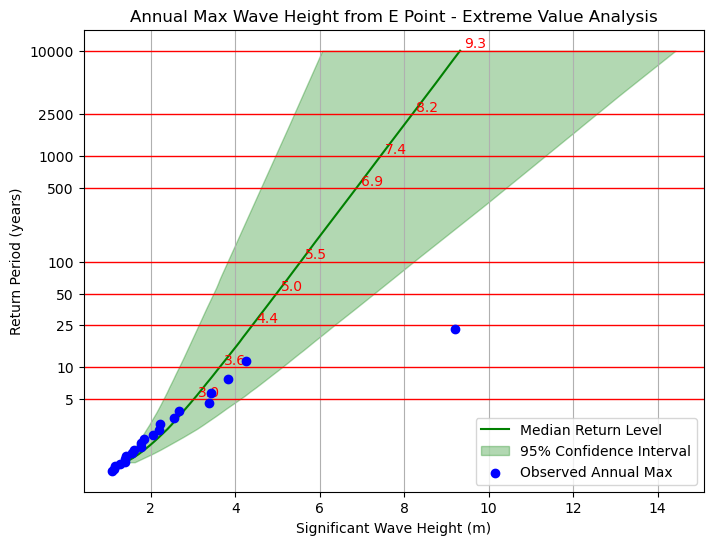

   Return Period (years)  Median Return Wave Height (m)  Lower 90% CI (m/s)  \
0                      5                       3.018739            2.298003   
1                     10                       3.628500            2.665691   
2                     25                       4.402551            3.130217   
3                     50                       4.975820            3.482067   
4                    100                       5.543774            3.815460   
5                    500                       6.865905            4.604042   
6                   1000                       7.432001            4.942641   
7                   2500                       8.186269            5.389010   
8                  10000                       9.320579            6.057736   

   Upper 90% CI (m/s)  Associated Wave Period (s)  
0            4.113160                    6.932258  
1            5.102672                    7.482764  
2            6.341027                    8.181594  
3

In [2]:
#method where you calculate median and confidence intervals from data sampled from observed annual maxima
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\East point\waveswind_eastpoint.csv')
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Filter for directional bin
directional_bin = (data['waved'] >= 146.25) & (data['waved'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum 
annual_max = filtered_data.groupby('year').agg(
    max_hsig=('hsig', 'max')
).reset_index()

# Print the observed annual maxima
print(annual_max)

# Define return periods for the analysis
return_periods_full = np.logspace(0.1, 4, 100)  # 1 to 10,000 years
n_bootstraps = 1000

# Create an array to store return levels for each bootstrap
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

# Bootstrapping from the observed annual maxima
for i in range(n_bootstraps):
    # Resample observed annual maxima with replacement
    resampled_annual_max = annual_max['max_hsig'].sample(frac=1, replace=True)
    
    # Fit Gumbel distribution to the resampled data
    params = gumbel_r.fit(resampled_annual_max)
    
    # Calculate return levels for the given return periods
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *params)

# Calculate 5th percentile (lower bound), 50th percentile (median), and 95th percentile (upper bound)
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 50, 95], axis=0)
lower_90_confidence = confidence_intervals_full[0, :]  # 5th percentile
median_return_levels = confidence_intervals_full[1, :]  # Median (50th percentile)
upper_90_confidence = confidence_intervals_full[2, :]  # 95th percentile

# Define specific return periods for summary table and labels
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_speed_levels = np.interp(
    highlighted_return_periods,
    return_periods_full,
    median_return_levels
)

# Linear regression function for waves > 3.5 meters
def associate_peak_periods(hsig_levels):
    valid_data = filtered_data[['hsig', 'pp1d']].dropna()

    # Filter for significant wave heights greater than 3 meters
    valid_data_above_3m = valid_data[valid_data['hsig'] > 3.5]

    # Perform linear regression on the valid data (hsig vs pp1d) for waves > 3 meters
    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data_above_3m['hsig'], valid_data_above_3m['pp1d'])

    # Generate the associated peak periods using the linear regression model
    associated_periods = slope * hsig_levels + intercept
    return associated_periods

# Calculate associated periods for the median return levels
associated_periods_median = associate_peak_periods(median_return_levels)

highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, lower_90_confidence)
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, upper_90_confidence)
highlighted_median_levels = np.interp(highlighted_return_periods, return_periods_full, median_return_levels)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, 
                  lower_90_confidence, upper_90_confidence, 
                  color='green', alpha=0.3, label='95% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated hsig levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_speed_levels[i] + 0.1, period, f"{highlighted_speed_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_hsig', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_hsig'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)

# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel('Significant Wave Height (m)')
plt.ylabel('Return Period (years)')
plt.title('Annual Max Wave Height from E Point - Extreme Value Analysis')
plt.legend()
plt.grid(True, which="both", axis="x")

plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wave_return_levels.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Create a summary DataFrame with return levels and confidence intervals
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Wave Height (m)': highlighted_speed_levels,
    'Lower 90% CI (m/s)': highlighted_ci_5,
    'Upper 90% CI (m/s)': highlighted_ci_95,
    'Associated Wave Period (s)': associate_peak_periods(highlighted_median_levels)
})

# Output the results
print(results)

output_file = r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wave_return_levels.xlsx"
results.to_excel(output_file, index=False)

print(f"Results have been saved to: {output_file}")

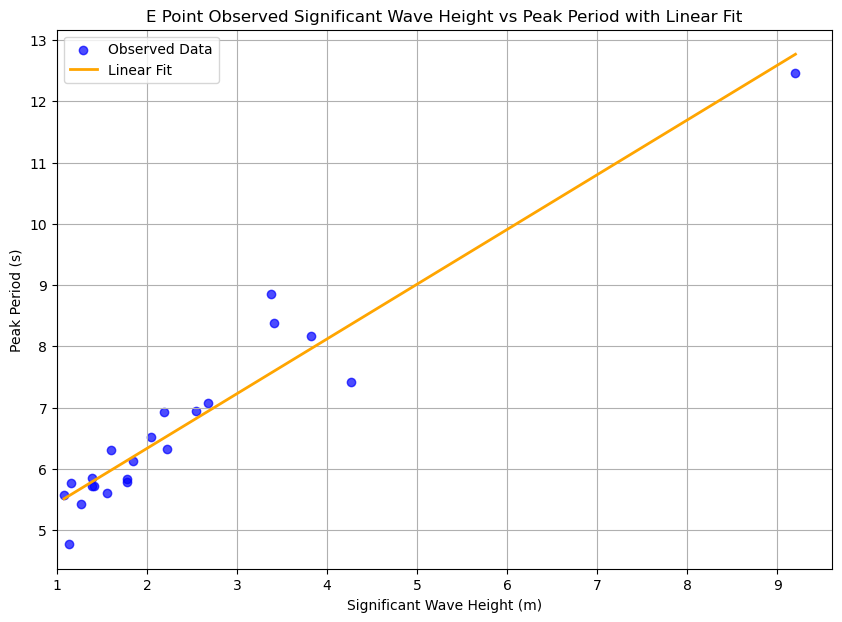

Linear Fit Equation: Peak Period (s) = 0.89 * Hs (m) + 4.55
R-squared value: 0.92


In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\East point\waveswind_eastpoint.csv')
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Filter for directional bin
directional_bin = (data['waved'] >= 146.25) & (data['waved'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum (hsig and pp1d together)
annual_max = filtered_data.loc[
    filtered_data.groupby('year')['hsig'].idxmax()
].reset_index(drop=True)

# Filter for significant wave heights greater than 0 meters
valid_data_above_3m = annual_max[annual_max['hsig'] > 0][['hsig', 'pp1d']].dropna()

# Linear regression: hsig vs pp1d for waves > 3.5 meters
slope, intercept, r_value, p_value, std_err = stats.linregress(
    valid_data_above_3m['hsig'], valid_data_above_3m['pp1d']
)

# Generate a range of hsig values for plotting the trend line
hsig_values = np.linspace(valid_data_above_3m['hsig'].min(), valid_data_above_3m['hsig'].max(), 100)
predicted_periods = slope * hsig_values + intercept

# Plotting the observed data points
plt.figure(figsize=(10, 7))
plt.scatter(valid_data_above_3m['hsig'], valid_data_above_3m['pp1d'], alpha=0.7, label='Observed Data', color='blue')

# Plotting the linear fit (trend line)
plt.plot(hsig_values, predicted_periods, color='orange', label='Linear Fit', linewidth=2)

# Labels and title
plt.xlabel('Significant Wave Height (m)')
plt.ylabel('Peak Period (s)')
plt.title('E Point Observed Significant Wave Height vs Peak Period with Linear Fit')

# Set x-axis to start at 1 meters
plt.xlim(left=1)

# Show legend
plt.legend()

# Show grid
plt.grid(True)

# Save the plot
plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_PPD.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Output the linear regression results
print(f"Linear Fit Equation: Peak Period (s) = {slope:.2f} * Hs (m) + {intercept:.2f}")
print(f"R-squared value: {r_value**2:.2f}")


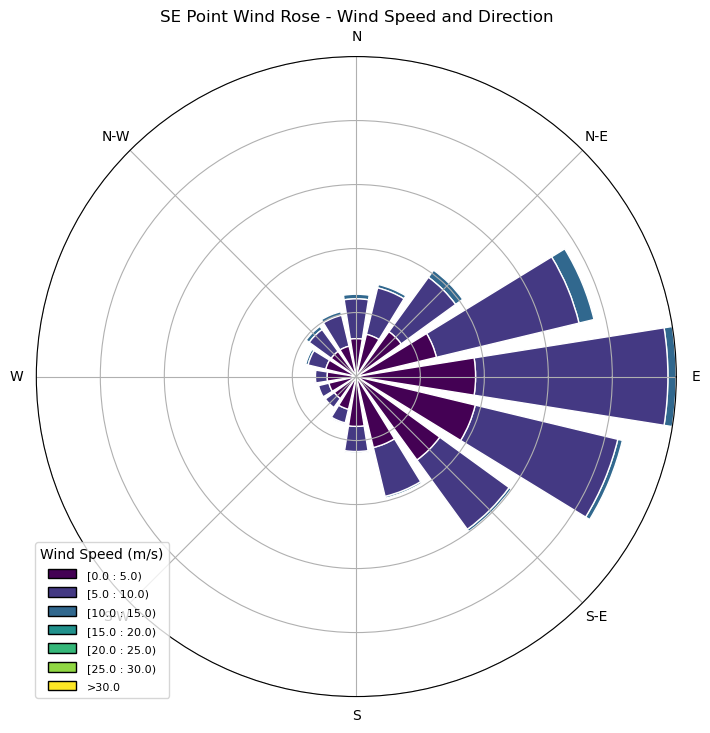

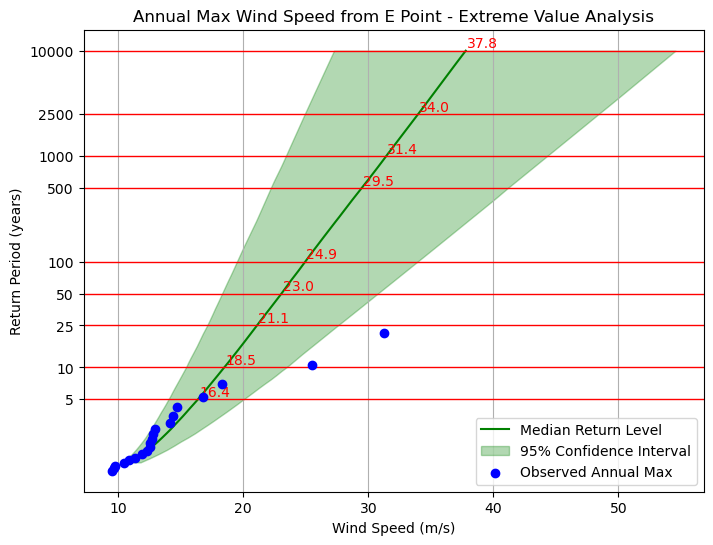

   Return Period (years)  Median Return Level Wind Speed (m/s)  \
0                      5                             16.382586   
1                     10                             18.478808   
2                     25                             21.098982   
3                     50                             23.046627   
4                    100                             24.943844   
5                    500                             29.466268   
6                   1000                             31.415687   
7                   2500                             33.969923   
8                  10000                             37.788534   

   Lower 90% CI (m/s)  Upper 90% CI (m/s)  
0           14.021370           20.038427  
1           15.411367           23.439600  
2           17.112704           27.570788  
3           18.296720           30.745176  
4           19.479954           33.908395  
5           22.194888           41.149066  
6           23.387716          

In [9]:
#Method where you resample from observed ann max 
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\East point\waveswind_eastpoint.csv')

# Convert 'valid_time' to datetime if necessary
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Plot a wind rose for the original data
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(data['windd'], data['windsp'], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, data['windsp'].max() + 1, 5))
ax.set_legend(title="Wind Speed (m/s)")
plt.title('SE Point Wind Rose - Wind Speed and Direction')
ax.yaxis.set_tick_params(labelleft=False, labelright=False)
plt.show()

# Filter for directional bin (ENE)
directional_bin = (data['windd'] >= 146.25) & (data['windd'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum wind speeds
annual_max = filtered_data.groupby('year').agg(
    max_wind_speed=('windsp', 'max')
).reset_index()

# Print the observed annual maxima
print(annual_max)

# Define return periods for the analysis
return_periods_full = np.logspace(0.1, 4, 100)  # 1 to 10,000 years
n_bootstraps = 1000

# Create an array to store return levels for each bootstrap
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

# Bootstrapping from the observed annual maxima
for i in range(n_bootstraps):
    # Resample observed annual maxima with replacement
    resampled_annual_max = annual_max['max_wind_speed'].sample(frac=1, replace=True)
    
    # Fit Gumbel distribution to the resampled data
    params = gumbel_r.fit(resampled_annual_max)
    
    # Calculate return levels for the given return periods
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *params)

# Calculate 5th percentile (lower bound), 50th percentile (median), and 95th percentile (upper bound)
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 50, 95], axis=0)
lower_90_confidence = confidence_intervals_full[0, :]  # 5th percentile
median_return_levels = confidence_intervals_full[1, :]  # Median (50th percentile)
upper_90_confidence = confidence_intervals_full[2, :]  # 95th percentile

# Define specific return periods for summary table and labels
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_speed_levels = np.interp(
    highlighted_return_periods,
    return_periods_full,
    median_return_levels
)
highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, lower_90_confidence)
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, upper_90_confidence)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, 
                  lower_90_confidence, upper_90_confidence, 
                  color='green', alpha=0.3, label='95% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated wind speed levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_speed_levels[i] + 0.1, period, f"{highlighted_speed_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_wind_speed', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_wind_speed'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)

# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Return Period (years)')
plt.title('Annual Max Wind Speed from E Point - Extreme Value Analysis')
plt.legend()
plt.grid(True, which="both", axis="x")

plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wind_return_levels.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Create a summary DataFrame with return levels and confidence intervals
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Level Wind Speed (m/s)': highlighted_speed_levels,
    'Lower 90% CI (m/s)': highlighted_ci_5,
    'Upper 90% CI (m/s)': highlighted_ci_95
})

# Output the results
print(results)


output_file = r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wind_return_levels.xlsx"
results.to_excel(output_file, index=False)

print(f"Results have been saved to: {output_file}")

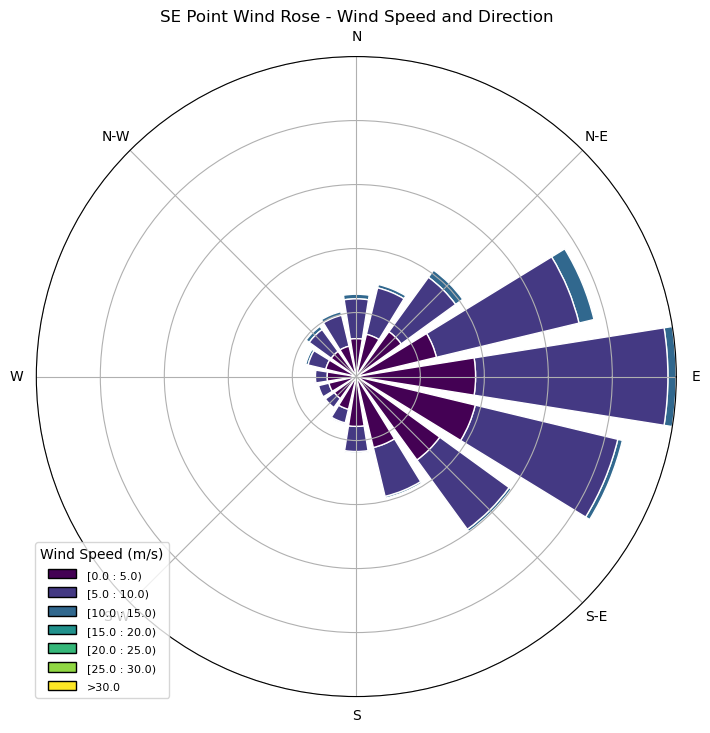

    year  max_wind_speed
0   2003       11.378842
1   2004       14.371503
2   2005       25.534463
3   2006        9.489832
4   2007       12.502137
5   2008       18.290633
6   2009       12.921739
7   2010       10.833730
8   2011       10.437217
9   2012       16.769666
10  2013       12.555493
11  2014        9.657174
12  2015        9.709497
13  2016       11.893956
14  2017       31.236551
15  2018       12.730034
16  2019       12.276001
17  2020       12.744125
18  2023       14.172792
19  2024       14.708224


In [1]:
#Method where you resample from observed ann max 
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\East point\waveswind_eastpoint.csv')

# Convert 'valid_time' to datetime if necessary
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Plot a wind rose for the original data
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(data['windd'], data['windsp'], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, data['windsp'].max() + 1, 5))
ax.set_legend(title="Wind Speed (m/s)")
plt.title('SE Point Wind Rose - Wind Speed and Direction')
ax.yaxis.set_tick_params(labelleft=False, labelright=False)
plt.show()

# Filter for directional bin (ENE)
directional_bin = (data['windd'] >= 146.25) & (data['windd'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum wind speeds
annual_max = filtered_data.groupby('year').agg(
    max_wind_speed=('windsp', 'max')
).reset_index()

# Print the observed annual maxima
print(annual_max)

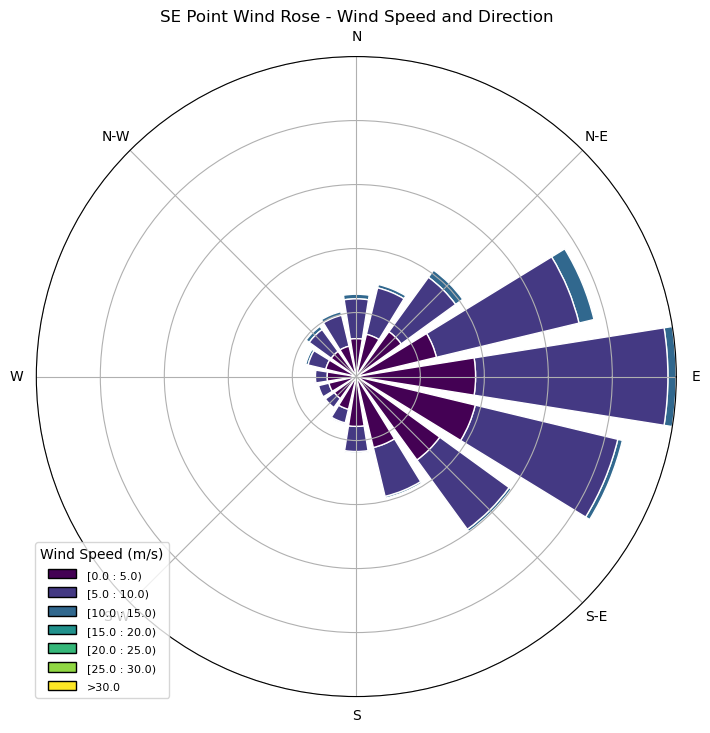

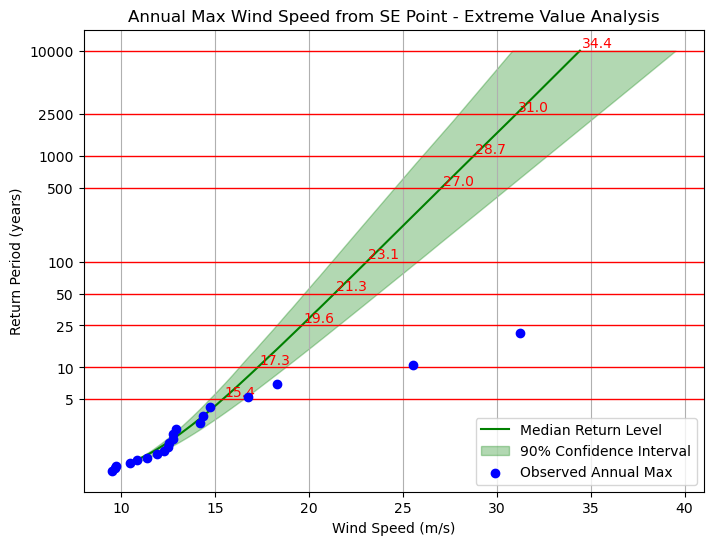

   Return Period (years)  Median Return Level Wind Speed (m/s)  \
0                      5                             15.399455   
1                     10                             17.255586   
2                     25                             19.606784   
3                     50                             21.340143   
4                    100                             23.057308   
5                    500                             27.032956   
6                   1000                             28.742636   
7                   2500                             31.019485   
8                  10000                             34.425097   

   Lower 90% CI (m/s)  Upper 90% CI (m/s)  
0           14.672580           16.484558  
1           16.248368           18.712623  
2           18.251513           21.540774  
3           19.716393           23.638678  
4           21.174554           25.730232  
5           24.534802           30.559946  
6           25.991536          

In [62]:
#Method where you resample from the entire dataset (not annual max), create synthetic data from the resampling to get synthetic annual maxima 
#Synthetic annual max is used to create medians and CIs
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\east point\waveswind_eastpoint.csv')

# Convert 'valid_time' to datetime if necessary
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Plot a wind rose for the original data
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(data['windd'], data['windsp'], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, data['windsp'].max() + 1, 5))
ax.set_legend(title="Wind Speed (m/s)")
plt.title('SE Point Wind Rose - Wind Speed and Direction')
ax.yaxis.set_tick_params(labelleft=False, labelright=False)
plt.show()

# Filter for directional bin (ENE)
directional_bin = (data['windd'] >= 146.25) & (data['windd'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum wind speeds
annual_max = filtered_data.groupby('year').agg(
    max_wind_speed=('windsp', 'max')
).reset_index()

# Define return periods
return_periods_full = np.logspace(0.1, 4, 100)  # 1 to 10,000 years

# Bootstrapping with the full dataset to calculate confidence intervals
n_bootstraps = 1000
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

# Bootstrapping from the full dataset to generate synthetic annual maxima
for i in range(n_bootstraps):
    # Resample with replacement from the full filtered dataset
    resampled_data = filtered_data.sample(frac=1, replace=True)

    # Compute the synthetic annual maxima for each year in the resampled data
    synthetic_annual_max = resampled_data.groupby('year').agg(max_wind_speed=('windsp', 'max')).reset_index()

    # Fit Gumbel distribution to the synthetic annual maxima
    resampled_params = gumbel_r.fit(synthetic_annual_max['max_wind_speed'])

    # Calculate return levels for this resample
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *resampled_params)

# Calculate 5%, 50% (median), and 95% confidence intervals across the full range
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 50, 95], axis=0)

#median to be the midpoint between 5% and 95% confidence intervals
median_return_levels = (confidence_intervals_full[0, :] + confidence_intervals_full[1, :]) / 2

# Now calculate symmetric 90% CI bounds centered around the median
lower_90_confidence = median_return_levels - (median_return_levels - confidence_intervals_full[0, :])
upper_90_confidence = median_return_levels + (confidence_intervals_full[2, :] - median_return_levels)

# Define specific return periods and calculate corresponding median return levels and CIs
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_speed_levels = np.interp(
    highlighted_return_periods,
    return_periods_full,
    median_return_levels
)
highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, lower_90_confidence)
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, upper_90_confidence)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, 
                  lower_90_confidence, upper_90_confidence, 
                  color='green', alpha=0.3, label='90% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated wind speed levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_speed_levels[i] + 0.1, period, f"{highlighted_speed_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_wind_speed', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_wind_speed'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)
# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Return Period (years)')
plt.title('Annual Max Wind Speed from SE Point - Extreme Value Analysis')
plt.legend()
plt.grid(True, which="both", axis="x")

plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\E_Wind_return_levels.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Create a summary DataFrame with return levels and confidence intervals
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Level Wind Speed (m/s)': highlighted_speed_levels,
    'Lower 90% CI (m/s)': highlighted_ci_5,
    'Upper 90% CI (m/s)': highlighted_ci_95
})

# Output the results
print(results)